In [24]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.cross_validation
import joblib

import fs_loader
import model
import plotting

%matplotlib inline


def select_single_valid_date(df, request):
    assert 'longitude' in df.columns and 'latitude' in df.columns
    spatial_df = df[df.valid_date.apply(lambda d: str(d).startswith(request['valid_date']))].copy()
    assert len(spatial_df) > 0, "date '%s' not contained in dataset." % request['valid_date']
    return spatial_df


def add_time_based_features(df):
    df['valid_hour'] = df['valid_date'].apply(lambda s: int(str(s)[-2:]))
    df['valid_month'] = df['valid_date'].apply(lambda s: int(str(s)[4:6]))
    

def calculate_error(df, request):
    predictant = request['predictant']
    model = request['model_name']
    obs_col = predictant + '_observed'

    main_predictor = predictant + '_' + model

    error = df[obs_col] - df[main_predictor]
    return error


def fit_model_and_return_dataset(gp, request):
    print("Loading dataset..")
    dataset = fs_loader.load_dataset(request)
    print("Done loading dataset.")
    # Modify dataset to fit geo-spatial problem
    dataset = select_single_valid_date(dataset, request)
    add_time_based_features(dataset)

    # Transform observation to error
    dataset[request['predictant'] + '_error'] = calculate_error(dataset, request)

    # TODO TdR 17/07/16: Randomly distort latitude and longitude by a small offset (100m).
    # TODO TdR 17/07/16: preserve original row-mapping for later reference
    # TODO TdR 19/07/16: Try feature embeddings
    y = dataset[[request['predictant'] + '_error']]
    X = dataset[[
        'latitude',
        'longitude'
    ]]
    
    # Temporary fix for scikit-learn 0.17.1. GPs in 0.18 can deal with duplicate features.
    duplicates = X.duplicated()
    y = y.loc[~duplicates].values
    X = X.loc[~duplicates].values
    print("Dataset has %d samples and %d features." % X.shape)

    # Make train / test split
    # TODO TdR 19/07/16: randomly split on station id. A realistic setting is all or nothing for specific locations.
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
        X, y, test_size=0.10)

    print("Training GP..")
    gp.fit(X_train, y_train)
    print("Done training GP.")

    # Validate model
    predictions = gp.predict(X_test)
    print("MAE: %.3f." % (sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=predictions)))
    print("RMSE: %.3f." % np.sqrt((sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=predictions))))
    return dataset


def predict_area(gp, request):
    top_lat, bot_lat, left_lon, right_lon = request['predict_area']
    res = request['predict_resolution']
    n_lons = int(np.ceil(abs(right_lon - left_lon) / res))
    n_lats = int(np.ceil(abs(top_lat - bot_lat) / res))
    x1, x2 = np.meshgrid(np.linspace(left_lon, right_lon, n_lons),
                         np.linspace(bot_lat, top_lat, n_lats))
    xx = np.vstack([x1.reshape(x1.size), x2.reshape(x2.size)]).T
    print("Predicting for %d points.." % len(xx))

#     y_pred, mse = chunked_predict(gp, xx)
    y_pred, mse = gp.predict(xx, eval_MSE=True)
    y_pred = y_pred.reshape((n_lons, n_lats))
    sigma = np.sqrt(mse)
    sigma = sigma.reshape((n_lons, n_lats))
    print("Done.")
    return y_pred, sigma


# def chunked_predict(gp, xx):
#     chunk_size = int(np.ceil(max(len(xx) / 8, 5000)))
#     predictions = []
#     mse = []
#     for i in range(chunk_size):
#         print("Predicting %d.." % (i*chunk_size))
#         chunk = xx[(i*chunk_size):((i+1)*chunk_size), :]
#         chunk_pred, chunk_mse = gp.predict(chunk, eval_MSE=True)
#         predictions.append(chunk_pred)
#         mse.append(chunk_mse)
#     return np.concatenate(predictions), np.concatenate(mse.append)


def plot_area(dataset, request, area_prediction):
    top_lat, bot_lat, left_lon, right_lon = request['predict_area']

    res = '50m'
    alpha = 1.0
    plt.figure(figsize=(15,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.axis('equal')
    plotting.add_background_map(ax, res, alpha)
    
    # Plot stations
    # sp = plt.scatter(
    #     dataset.longitude, dataset.latitude, 
    #     s=10, c=dataset['TT2m_error'], 
    #     edgecolor='face',
    #     vmin=-5, vmax=5,
    # )
    
    # Plot area
    cax = plt.imshow(
        # TODO TdR 22/07/16: is the flipud really necessary?
        np.flipud(area_prediction), alpha=1,
        extent=(left_lon, right_lon, bot_lat, top_lat),
        # vmin=_min, vmax=_max
    )
    
    # cs = plt.contour(
    #     np.flipud(area_prediction),
    #     extent=(left_lon, right_lon, bot_lat, top_lat),
    #     antialiased=True,
    # )
    # plt.clabel(cs, fontsize=11)

    cb = plt.colorbar(cax)
    cb.set_label('Temperature error')
    plt.show()
    

def plot_prediction_distribution(prediction):
    plt.figure()
    plt.title("Prediction distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Temperature error")
    plt.hist(prediction, np.arange(-5, 5, 1))
    plt.show()

Loading dataset..
Done loading dataset.
Dataset has 3919 samples and 2 features.
Training GP..
Given autocorrelation parameters. Computing Gaussian Process model parameters...
Done training GP.
MAE: 0.898.
RMSE: 1.441.
Predicting for 3456 points..
Done.


/Users/tomdr/VirtualEnvs/work-py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 54 x 64)
  '(shape is %d x %d)' % inp.shape[::-1])


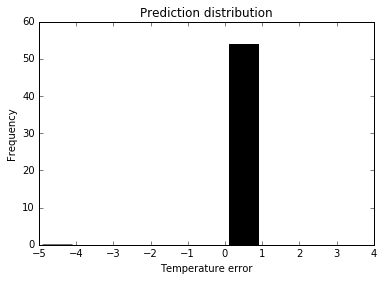

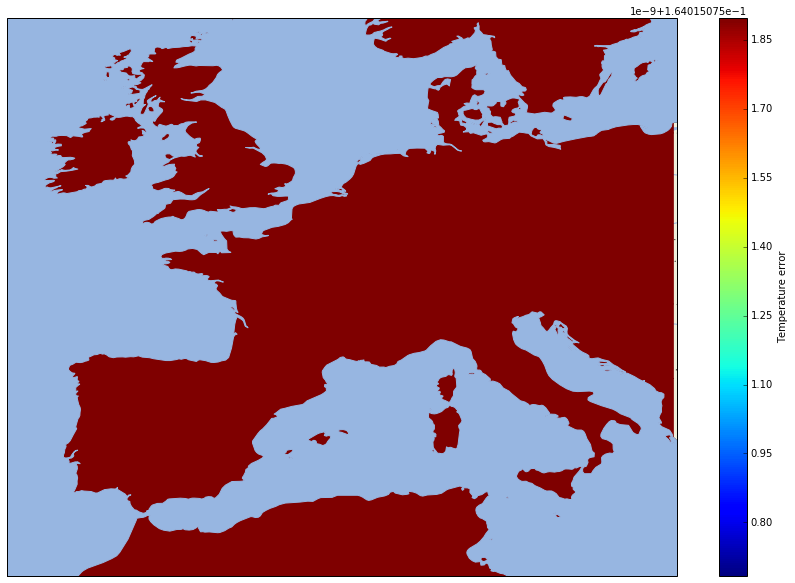

In [25]:
import sklearn.gaussian_process as skgp

test_request = {
    'predictant': 'TT2m',
    'model_elements': ['TT2m', 'FF10m'],
    'forecast_hours': [18],
    'model_name': 'ModelMix',
    'valid_date': '20151201',
    'predict_area': (60, 33, -12, 20),
    'predict_resolution': 0.5
}

gp = skgp.GaussianProcess(
    regr='constant',
    corr='squared_exponential',
    beta0=None,           # Regression weight of Ordinary Kriging
    storage_mode='full',  # Store Cholesky decomposition of Corr.
#     theta0=5e-1,          # Parameters of autocorrelation
    normalize=False,       # Standard Gaussian normalization of input
    nugget=0.5,
    optimizer='fmin_cobyla',
    verbose=True
)

dataset = fit_model_and_return_dataset(gp, test_request)
area_prediction, area_std = predict_area(gp, test_request)
plot_prediction_distribution(area_prediction)
plot_area(dataset, test_request, area_prediction)

In [ ]:
# Data visualisation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import fs_loader
import plotting
import model
import main
%matplotlib inline


def plot_station_errors(request, fh):
    dataset = fs_loader.load_dataset(request)
    dataset = main.select_single_valid_date(dataset, request)
    dataset[test_request['predictant'] + '_error'] = model.calculate_error(dataset, request)
    
    res = '50m'
    alpha = 1.0
    plt.figure(figsize=(15,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.axis('equal')
    ax.set_extent((-12, 20, 33, 60))
    plotting.add_background_map(ax, res, alpha)
    
    # Plot stations
    plt.scatter(
        dataset.longitude, dataset.latitude, 
        s=10, c=dataset[test_request['predictant'] + '_error'], 
        edgecolor='face',
        vmin=-5, vmax=5,
    )

    cb = plt.colorbar()
    cb.set_label('Value')
    plt.show()


for fh in range(12, 13):
    test_request = {
        'predictant': 'TT2m',
        'model_elements': ['TT2m', 'FF10m'],
        'forecast_hours': [fh],
        'model_name': 'EURO4',
        'valid_date': '20151111'
    }
    print("Forecast hour %d" % fh)
    plot_station_errors(test_request, fh)